# Creating baseline performance for MPI


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-09-12 15:03:16.591518: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
mpi_data_path = "../../data/mpi_001"


def read_xarray_mpi(dir_name="",num="006"):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature
    '''
    date="198201-201701"
  
    file_type ="MPI"
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)
xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_1425892/514179119.py:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")


In [7]:
xco2_df = pd.DataFrame()
xco2_df["XCO2"] = xco2.XCO2
xco2_df.index = xco2.time

data_read=xr.merge([mld.MLD,mld.MLD_socat,chl.Chl,chl.Chl_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat])
#data_read=xr.merge([mld.MLD,chl.Chl,sst.SST,sss.SSS])



tmp_data=data_read.to_dataframe().reset_index()
tmp_data["time"] = tmp_data["time"].dt.strftime("%Y-%m")
tmp_data = xco2_df.join(tmp_data.set_index('time'),how = "right")

In [8]:
tmp_data

,XCO2,xlon,ylat,MLD,MLD_socat,Chl,Chl_socat,SST,SST_socat,SSS,SSS_socat
1982-01,NaN,0.5,-89.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01,NaN,0.5,-88.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01,NaN,0.5,-87.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01,NaN,0.5,-86.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01,NaN,0.5,-85.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-01,406.971283,359.5,85.5,30.801374,0.0,0.000620,0.0,-1.900000,-0.0,31.889488,0.0
2017-01,406.971283,359.5,86.5,49.919544,0.0,0.000676,0.0,-1.899847,-0.0,31.988329,0.0
2017-01,406.971283,359.5,87.5,55.857330,0.0,0.000617,0.0,-1.899542,-0.0,31.618706,0.0
2017-01,406.971283,359.5,88.5,56.759087,0.0,0.000544,0.0,-1.899695,-0.0,31.298952,0.0


In [9]:
tmp_data = tmp_data.reset_index()
pco2_data = pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat = pco2.pCO2_socat.to_dataframe().reset_index()

# tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
# tmp_data["Chl"]=chl_data["Chl"]
tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]

features_socat = ['xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data[features_socat]
combined=tmp_data[features]

In [10]:
# drop rows where pco2 or pco2_socat == NA or 0
combined_socat.dropna(subset = ["pCO2_socat"], inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]

combined.dropna(subset = ["pCO2"], inplace=True)
combined.dropna(subset = ["SSS"], inplace=True)

combined = combined[combined['pCO2']!=0]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [11]:
combined.isna().sum()

xlon        0
ylat        0
MLD         0
SST         0
SSS         0
Chl         0
XCO2    24930
pCO2        0
dtype: int64

In [12]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
X_socat=combined_socat.iloc[:,:-1]
X=combined.iloc[:,:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']



In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)

regressor=RandomForestRegressor(n_estimators=20, random_state=42, verbose=3,n_jobs=-1, 
                                max_depth=10,warm_start= True)
regressor.fit(X_train, y_train)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20building tree 6 of 20
building tree 7 of 20

building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[P

Scores: [29.21806014 29.45477306 29.82340263]
Mean: 29.498745273154253
Standard deviation: 0.24907836615694148


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


In [15]:
y_pred=regressor.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


29.415065045087008

In [16]:
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.2s finished


46.46603201190586

In [17]:
## Full Data
# rmse with MLD : 40.462 uatm -> 
# rmse with Dist : 41.541 uatm  -> 32.84 uatm with coordinate

## Socat 
# # rmse with MLD : 46.46603201190586 uatm with coordinate

In [19]:
predicted_df = pd.DataFrame(X, columns = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'])
predicted_df["pred"] = y_pred

In [20]:
new_df = pd.merge(tmp_data, predicted_df,  how='left', left_on=['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'], right_on = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'])


In [21]:
res = new_df.pCO2 - new_df.pred

In [22]:
col_names = ["time","lon","lat","pred"]

pred_df = new_df[["index","xlon","ylat","pred"]]
pred_df.columns = col_names
pred_df['time'] = pd.to_datetime(pred_df['time'])
pred_df = pred_df.set_index(["time","lat","lon"])


col_names = ["time","lon","lat","res"]

res_df = new_df[["index","xlon","ylat"]]
res_df["residual"]=res
res_df.columns = col_names
res_df['time'] = pd.to_datetime(res_df['time'])
res_df = res_df.set_index(["time","lat","lon"])


pred_xarray = pred_df.to_xarray()
res_xarray = res_df.to_xarray()



/tmp/ipykernel_1425892/3780070735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['time'] = pd.to_datetime(pred_df['time'])
/tmp/ipykernel_1425892/3780070735.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df["residual"]=res
/tmp/ipykernel_1425892/3780070735.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [23]:
pred_xarray

<xarray.Dataset>
Dimensions:  (time: 421, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2017-01-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    pred     (time, lat, lon) float64 nan nan nan nan ... 314.5 315.3 315.3

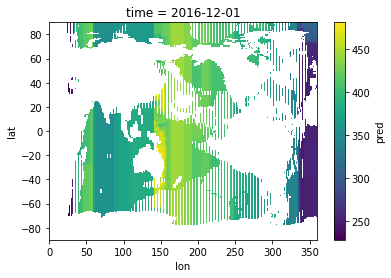

In [24]:

pred_xarray.pred[419].plot()

plt.show()

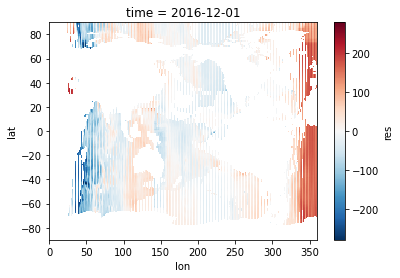

In [30]:
res_xarray.res[419].plot()

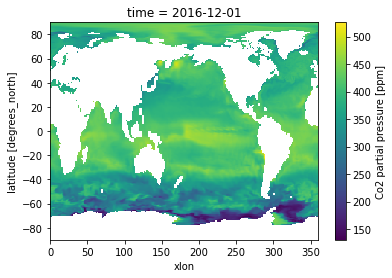

building tree 3 of 20
building tree 5 of 20
building tree 9 of 20
building tree 13 of 20
building tree 17 of 20
building tree 1 of 20
building tree 5 of 20
building tree 9 of 20
building tree 10 of 20
building tree 18 of 20
building tree 3 of 20
building tree 6 of 20
building tree 11 of 20
building tree 12 of 20
building tree 18 of 20
building tree 4 of 20
building tree 6 of 20
building tree 10 of 20
building tree 14 of 20
building tree 18 of 20
building tree 2 of 20
building tree 7 of 20
building tree 15 of 20
building tree 16 of 20
building tree 20 of 20
building tree 4 of 20
building tree 8 of 20
building tree 15 of 20
building tree 16 of 20
building tree 19 of 20
building tree 2 of 20
building tree 7 of 20
building tree 11 of 20
building tree 16 of 20
building tree 20 of 20
building tree 4 of 20
building tree 8 of 20
building tree 13 of 20
building tree 14 of 20
building tree 19 of 20
building tree 2 of 20
building tree 7 of 20
building tree 13 of 20
building tree 14 of 20
building

In [26]:
pco2.pCO2[419].plot()

In [85]:
pco2.pCO2

<xarray.DataArray 'pCO2' (time: 421, ylat: 180, xlon: 360)>
[27280800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2017-01-01
  * xlon     (xlon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  co2_partial_pressure
    long_name:      Co2 partial pressure
    units:          ppm
    code:           67
    cell_methods:   depth: mean